#### A quick demonstration of bias-hardened lensing estimator in fullsky

In [1]:
import numpy as np, basic, curvedsky, plottools as pl, healpy as hp
from matplotlib.pyplot import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
lmax  = 2048       # maximum multipole of output normalization
rlmin, rlmax = 100, lmax  # reconstruction multipole range
sig   = 10.
ac2rad = np.pi/180./60.
L = np.linspace(0,lmax,lmax+1)

#### Load unlensed and lensed Cls

In [3]:
lcl = basic.aps.read_cambcls('../data/lensedcls.dat',2,lmax,4,bb=True)/Tcmb**2
nl  = np.zeros((4,lmax+1))
nl[0,:] = (sig*ac2rad/Tcmb)**2
nl[1,:] = 2*nl[0,:]
nl[2,:] = 2*nl[0,:]
ocl = lcl + nl

#### Calculate normalizations

In [4]:
Alpp = curvedsky.norm_quad.qtt('lens',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:],lfac='k')[0]
Alss = curvedsky.norm_quad.qtt('src',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])[0]

In [5]:
Rlps = curvedsky.norm_quad.xtt('lenssrc',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:],lfac='k')

In [6]:
DetR = 1 - Alpp*Alss*Rlps**2

In [7]:
Blpp = 1./DetR * Alpp
Blps = (-Rlps)/DetR * Alpp * Alss

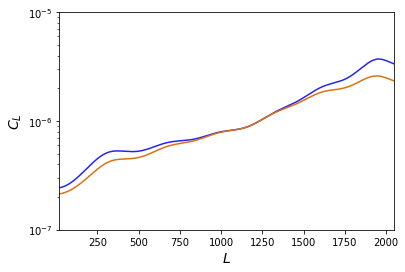

In [8]:
pl.plot_1dstyle(ylog=True,ymin=1e-7,ymax=1e-5)
plot(Blpp)
plot(Alpp)

#### Generating ptsr

In [9]:
# simple diagonal c-inverse
Fl = np.zeros((3,lmax+1,lmax+1))
for l in range(rlmin,rlmax):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

In [10]:
nside = 2048
npix  = 12*nside**2

In [11]:
# alm of ptsr
l = np.linspace(0,lmax,lmax+1)
bl = np.sqrt((2*l+1)/4./np.pi)
palm = np.ones((lmax+1,lmax+1),dtype=np.complex128) * 2e-9 * bl[:,None]
for l in range(lmax+1):  palm[l,1:] = 0.
ptsr = curvedsky.utils.hp_alm2map(nside,lmax,lmax,palm)

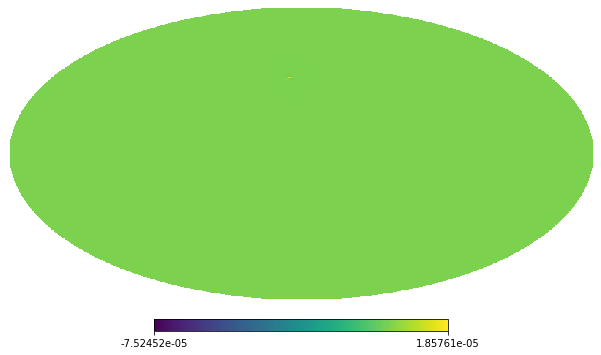

In [12]:
hp.mollview( ptsr, rot=[100,50,10], title="" )

In [13]:
s2lm = curvedsky.utils.hp_map2alm(nside,lmax,lmax,ptsr**2) * 4*np.pi / ((lmax)*(lmax+1))

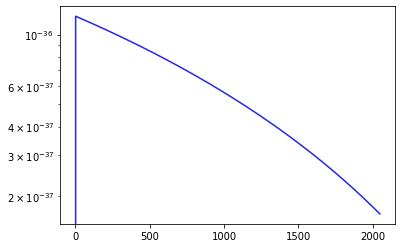

In [14]:
# power spectrum of s2 fields
yscale('log')
cls2 = curvedsky.utils.alm2cl(lmax,s2lm)
plot(cls2)

#### Run simulation

In [15]:
# if you want to change position of ptsr
#rot = hp.rotator.Rotator(rot=[10.,10.,20.])
#rptsr = rot.rotate_map_pixel(ptsr)
#hp.cartview(rptsr)

In [16]:
# generate CMB alms 
# - gaussian alms are generated, and the reconstructed cls are equal to the normalization
Talm, Ealm, Balm = curvedsky.utils.gaussTEB(lmax,lcl[0,:],lcl[1,:],lcl[2,:],lcl[3,:])

In [17]:
# add noise
Talm += curvedsky.utils.gauss1alm(lmax,nl[0,:])

In [18]:
Talm += palm

In [19]:
# diagonal filtering
Talm *= Fl[0,:,:]

In [20]:
almp, __ = curvedsky.rec_lens.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm,Talm,gtype='k')

In [21]:
alms = curvedsky.rec_src.qtt(lmax,rlmin,rlmax,Talm,Talm)

In [22]:
# make bias-hardened estimator
blmp = Blpp[:,None]*almp + Blps[:,None]*alms

In [23]:
# normalized estimator
almp *= Alpp[:,None]
alms *= Alss[:,None]

In [24]:
# compute cross spectra
clpp = curvedsky.utils.alm2cl(lmax,almp)
clss = curvedsky.utils.alm2cl(lmax,alms)
xlss = curvedsky.utils.alm2cl(lmax,alms,s2lm)
bhpp = curvedsky.utils.alm2cl(lmax,blmp)

#### Reconstructed ptsr map

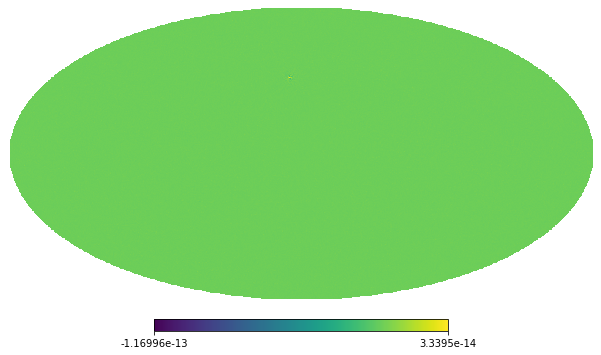

In [25]:
hp.mollview( curvedsky.utils.hp_alm2map(nside,lmax,lmax,alms), rot=[100,50,10], title="" )

#### Normal estimator which is biases by ptsr contributions

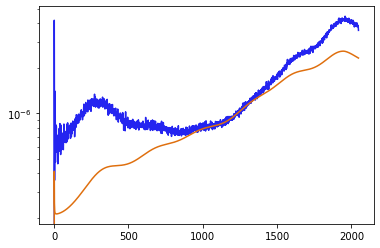

In [26]:
yscale('log')
plot(clpp,label='sim')
plot(Alpp,label='expected')

#### Bias hardened estimator

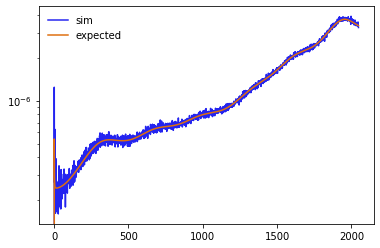

In [27]:
yscale('log')
plot(bhpp,label='sim')
plot(Blpp,label='expected')
legend()